# Predicting the IMDb rating of Arrow (American TV Serie) through scripts
## From the site: https://subslikescript.com/ 
## by: Anna Luiza Gomes

# Obs:
## 1. O primeiro jupyter notebook se refere ao webscraping dos scripts e a associacao a topicos de forma nao supervisionada usando LDA (este arquivo), o segundo se refere ao webscraping da pagina da serie no Wikipedia para obter a informacao de quantos users viram a serie e seus diretores e por último, a montagem do dataset final com o objetivo de obter o rating do IMBd de cada episodio.

## 2. Como próximo passo pretendo refinar o modelo LDA e aplicar Lemmatização e Stemização na etapa de pré-processamento dos dados, pois ainda nao consegui devido a erros que nao consegui solucionar. Também pretendo entender e melhorar o algoritmo de CART que no desenvolvimento final deu erro.  

## 3. Irei continuar o estudo de LDA e aprimorar o paper com mais base teórica e trabalhos de referencia...como mudei muito de caminho ao longo do desenvolvimento certos artigos nao seriam mais relevantes ao trabalho, por isso a parte textual nao esta muito desenvolvida.

## 4. Estou fazendo este trabalho no github, se quiser posso disponibilizar o link tambem. Como nao está pronto, o repositorio esta fechado, mas ai pode me mandar um email (annalgs@id.uff.br) ou mensagem (992043770) que encaminho o link.

In [28]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV # para o grid search
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

In [2]:
# configuração para não exibir os warnings

import warnings
warnings.filterwarnings("ignore")

# ignorando future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [3]:
scripts = pd.read_csv('Data/scripts.csv', sep=";")

In [4]:
scripts.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
scripts.head()

,nome_ep,Episodios,text_processed,0,1,2,nota_imdb,qtd_reviews,Topic
0,/series/Arrow-2193021/season-1/episode-1-Pilot,The name of the islandthey found me on is Lian...,the name of the islandthey found me on is lian...,0.287473,0.652349,0.060177,8.5,7572,1
1,/series/Arrow-2193021/season-1/episode-2-Honor...,[PANTING][GRUNTS][SPEAKING IN FOREIGN LANGUAGE...,[panting][grunts][speaking in foreign language...,0.735218,0.034977,0.229805,8.2,5731,0
2,/series/Arrow-2193021/season-1/episode-3-Lone_...,"My name is Oliver Queen.To my family, I am the...",my name is oliver queen to my family i am the...,0.025055,0.160141,0.814804,8.4,5367,2
3,/series/Arrow-2193021/season-1/episode-4-An_In...,"My name is Oliver Queen.For 5 years, I was str...",my name is oliver queen for 5 years i was str...,0.100796,0.415217,0.483987,8.3,5071,2
4,/series/Arrow-2193021/season-1/episode-5-Damaged,"OLIVER:My name is Oliver Queen.For five years,...",oliver:my name is oliver queen for five years ...,0.755971,0.149650,0.094378,8.6,5011,0


In [6]:
scripts.shape

(165, 9)

In [7]:
wiki = pd.read_csv('Data/wikipedia.csv', sep=";")

In [8]:
wiki.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
# the script is missing the episodes 12,13,14 from season 7 and episode 4 from season 3
# plus episode 18 from season 2 which is in portuguese
wiki.loc[[40,49,149,150,151]]  

,No.overall,No. inseason,Title,Directed by,Written by,Original air date,Prod.code,U.S. viewers(millions)
40,41,18,"""Deathstroke""",Guy Bee,Marc Guggenheim & Drew Z. Greenberg,"April 2, 2014",2J7468,2.32[49]
49,50,4,"""The Magician""",John Behring,Marc Guggenheim & Wendy Mericle,"October 29, 2014",3J5154,2.49[58]
149,150,12,"""Emerald Archer""",Glen Winter,Marc Guggenheim & Emilio Ortega Aldrich,"February 4, 2019",T27.13662,1.07[159]
150,151,13,"""Star City Slayer""",Gregory Smith,Beth Schwartz & Jill Blankenship,"February 11, 2019",T27.13663,1.09[160]
151,152,14,"""Brothers & Sisters""",Marcus Stokes,Rebecca Bellotto & Jeane Wong,"March 4, 2019",T27.13664,0.89[161]


In [10]:
wiki = wiki.drop(wiki.index[[40,49,149,150,151]]) #removing line 40

In [11]:
wiki = wiki.reset_index(drop=True)

In [12]:
wiki.shape

(165, 8)

In [13]:
dataset = pd.concat([wiki, scripts], axis=1) 

In [14]:
dataset.columns

Index(['No.overall', 'No. inseason', 'Title', 'Directed by', 'Written by',
       'Original air date', 'Prod.code', 'U.S. viewers(millions)', 'nome_ep',
       'Episodios', 'text_processed', '0', '1', '2', 'nota_imdb',
       'qtd_reviews', 'Topic'],
      dtype='object')

In [15]:
dataset[['viewers(millions)','residual']] = dataset['U.S. viewers(millions)'].str.split('[',expand=True)

In [16]:
dataset.drop(['U.S. viewers(millions)','residual','Title','text_processed','nome_ep','Topic','Episodios', 'No.overall', 'No. inseason', 'Written by', 'Prod.code', 'Original air date'], axis = 1 ,inplace = True)

In [17]:
dataset = dataset[[ 'Directed by', 'qtd_reviews', '0','1','2', 'viewers(millions)',  'nota_imdb']]

In [18]:
dataset.columns = ['Directed_by',  'qtd_reviews', '0','1','2','viewers(millions)',  'nota_imdb']

In [19]:
dataset.head()

,Directed_by,qtd_reviews,0,1,2,viewers(millions),nota_imdb
0,David Nutter,7572,0.287473,0.652349,0.060177,4.14,8.5
1,David Barrett,5731,0.735218,0.034977,0.229805,3.55,8.2
2,Guy Bee,5367,0.025055,0.160141,0.814804,3.51,8.4
3,Vince Misiano,5071,0.100796,0.415217,0.483987,3.05,8.3
4,Michael Schultz,5011,0.755971,0.149650,0.094378,3.75,8.6


In [20]:
dataset["viewers(millions)"] = pd.to_numeric(dataset["viewers(millions)"])

In [21]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Directed_by        165 non-null    object 
 1   qtd_reviews        165 non-null    int64  
 2   0                  165 non-null    float64
 3   1                  165 non-null    float64
 4   2                  165 non-null    float64
 5   viewers(millions)  165 non-null    float64
 6   nota_imdb          165 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 9.1+ KB


## Splitting the dataset in test and train for clusterization

In [22]:
from sklearn.preprocessing import OrdinalEncoder

# definindo a transformação ordinal encoding
encoder = OrdinalEncoder()

# transformando os dados
dataset[["Directed_by"]] = encoder.fit_transform(dataset[["Directed_by"]])

In [23]:
dataset.head()

,Directed_by,qtd_reviews,0,1,2,viewers(millions),nota_imdb
0,9.0,7572,0.287473,0.652349,0.060177,4.14,8.5
1,7.0,5731,0.735218,0.034977,0.229805,3.55,8.2
2,18.0,5367,0.025055,0.160141,0.814804,3.51,8.4
3,49.0,5071,0.100796,0.415217,0.483987,3.05,8.3
4,40.0,5011,0.755971,0.149650,0.094378,3.75,8.6


In [24]:
# separando os atributos e a classe do dataset
array = dataset.values
X = array[:,0:6]
Y = array[:,6]

# definindo o tamanho do conjunto de teste
test_size = 0.20 

# A semente (seed) pode ser qualquer número, e garante que os resultados possam ser reproduzidos de forma idêntica toda vez que o script for rodado. 
# Isto é muito importante quando trabalhamos com modelos ou métodos que utilizam de algum tipo de aleatoriedade.
seed = 7

# particionando em conjuntos de treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [25]:
X

array([[9.00000000e+00, 7.57200000e+03, 2.87473172e-01, 6.52349412e-01,
        6.01773895e-02, 4.14000000e+00],
       [7.00000000e+00, 5.73100000e+03, 7.35218167e-01, 3.49773057e-02,
        2.29804546e-01, 3.55000000e+00],
       [1.80000000e+01, 5.36700000e+03, 2.50554122e-02, 1.60140887e-01,
        8.14803720e-01, 3.51000000e+00],
       [4.90000000e+01, 5.07100000e+03, 1.00796103e-01, 4.15216684e-01,
        4.83987212e-01, 3.05000000e+00],
       [4.00000000e+01, 5.01100000e+03, 7.55971313e-01, 1.49650171e-01,
        9.43784639e-02, 3.75000000e+00],
       [2.40000000e+01, 4.74900000e+03, 2.03703698e-02, 7.01274037e-01,
        2.78355628e-01, 3.83000000e+00],
       [8.00000000e+00, 4.66400000e+03, 1.33426283e-02, 3.97993140e-02,
        9.46858108e-01, 3.74000000e+00],
       [2.80000000e+01, 4.53900000e+03, 4.07098681e-02, 4.37651187e-01,
        5.21638989e-01, 3.35000000e+00],
       [2.50000000e+01, 4.35300000e+03, 2.40394890e-01, 7.57118165e-01,
        0.00000000e+00, 

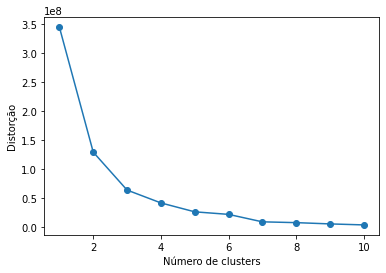

In [29]:
# Cria um array para armazenar os erros
distortions = []

# Cria modelos com k variando de 1 a 11, usando os mesmos parâmetros do modelo anterior
for i in range(1, 11):
    modelo = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    modelo.fit(X)
    distortions.append(modelo.inertia_) # inertia_ : Soma das distâncias quadráticas dos pontos ao centróide de cluster mais próximo.

# Configura e exibe o gráfico
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Distorção')
plt.show()

### Ideal number of clusters = 3

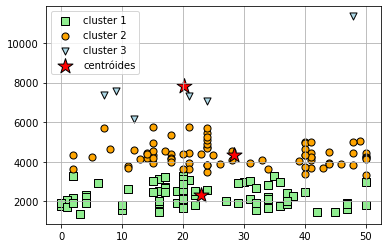

In [30]:
# Criação do modelo
modelo = KMeans(
    n_clusters=3,   # número de clusters
    init='random',  # método de inicializaçãp
    n_init=10,      # número de execuções com diferentes centróides aleatórios para escolher o modelo final
    max_iter=300,   # número máximo de iterações para cada execução única
    tol=1e-04,      # = 0,0001 - controla a tolerância com relação às alterações no erro quadrático dentro do cluster para declarar convergência
    random_state=0  # semente
)

# Predição dos clusters
y_km = modelo.fit_predict(X)

# Plotagem dos 3 clusters
plt.scatter(
    X[y_km == 0, 0], X[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    X[y_km == 1, 0], X[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    X[y_km == 2, 0], X[y_km == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

# Plotagem dos centróides
plt.scatter(
    modelo.cluster_centers_[:, 0], modelo.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centróides'
)

# Legenda do gráfico
plt.legend(scatterpoints=1)

# Exibição do gráfico com clusters e centróides
plt.grid()
plt.show()

In [31]:
# Imports
#import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [32]:
# definindo o tamanho do conjunto de teste
test_size = 0.20 

# A semente (seed) pode ser qualquer número, e garante que os resultados possam ser reproduzidos de forma idêntica toda vez que o script for rodado. 
# Isto é muito importante quando trabalhamos com modelos ou métodos que utilizam de algum tipo de aleatoriedade.
seed = 7

# definindo a métrica de avaliação dos algoritmos
scoring = 'neg_mean_squared_error' 
# scoring = 'r2'

# particionando em conjuntos de treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

kfold = KFold(n_splits=10)

In [35]:
model = DecisionTreeRegressor(random_state=seed)
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(abs(results.mean()))

0.7507252747252748


In [34]:
model = SVR()
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(abs(results.mean()))

0.369637294038608


In [36]:
model = KNeighborsRegressor()
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(abs(results.mean()))

0.4209138461538461


In [38]:
model = ElasticNet()
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(abs(results.mean()))

0.36596167340800206


In [39]:
model = Lasso()
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(abs(results.mean()))

0.3656951063089046


In [40]:
model = Ridge()
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(abs(results.mean()))

0.3630818976130649


In [41]:
model = LinearRegression()
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(abs(results.mean())) 

0.3777440864821123


LR: MSE 0.37 (0.34) - RMSE 0.61
Ridge: MSE 0.37 (0.35) - RMSE 0.61
Lasso: MSE 0.38 (0.32) - RMSE 0.62
ElasticNet: MSE 0.38 (0.32) - RMSE 0.62
KNN: MSE 0.45 (0.28) - RMSE 0.67
CART: MSE 0.78 (0.50) - RMSE 0.88
SVM: MSE 0.39 (0.33) - RMSE 0.63


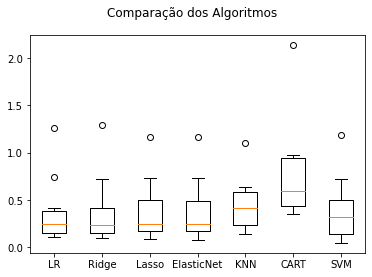

In [42]:
# Lista de modelos a avaliar
models = []
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('ElasticNet', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor(random_state=seed)))
models.append(('SVM', SVR()))


# Treinamento e avaliação de cada modelo
results = []
names = []  
for name, model in models:
  kfold = KFold(n_splits=10)
  cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
  results.append(abs(cv_results))
  names.append(name)
  # imprime MSE, desvio padrão do MSE e RMSE
  msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (name, abs(cv_results.mean()), cv_results.std(), np.sqrt(abs(cv_results.mean())))
  print(msg)

# Comparação dos algoritmos em boxplot
fig = plt.figure()
fig.suptitle('Comparação dos Algoritmos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

ScaledLR: 0.377744 (0.257419)
ScaledRidge: 0.363898 (0.276477)
ScaledLasso: 0.425020 (0.221469)
ScaledElasticNet: 0.425020 (0.221469)
ScaledKNN: 0.373515 (0.198759)
ScaledCART: 0.750725 (0.572466)
ScaledSVM: 0.350500 (0.245394)


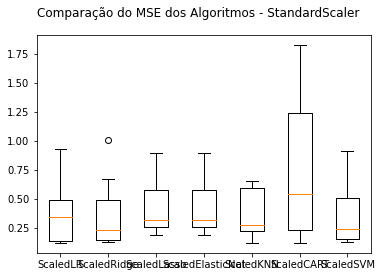

In [43]:
# Pipelines para padronização do dataset e aplicação do modelo
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('ScaledRidge', Pipeline([('Scaler', StandardScaler()),('Ridge', Ridge())])))
pipelines.append(('ScaledLasso', Pipeline([('Scaler', StandardScaler()),('Lasso', Lasso())])))
pipelines.append(('ScaledElasticNet', Pipeline([('Scaler', StandardScaler()),('ElasticNet', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor(random_state=seed))])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVR())])))
results = []
names = []

# Aplicação dos pipelines
for name, model in pipelines:
  kfold = KFold(n_splits=10)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(abs(cv_results))
  names.append(name)
  msg = "%s: %f (%f)" % (name, abs(cv_results.mean()), cv_results.std())
  print(msg)

# boxplot de comparação dos algoritmos
fig = plt.figure() 
fig.suptitle('Comparação do MSE dos Algoritmos - StandardScaler') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names) 
plt.show()

In [44]:
# padronização dos dados
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

In [45]:
alphas = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20, 50, 100]

# ----- Ridge
param_grid = dict(alpha=alphas)
model = Ridge()

# busca exaustiva de hiperparâmetros com GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

# imprime o melhor resultado
print("Melhor Ridge: %f usando %s" % (abs(grid_result.best_score_), grid_result.best_params_)) 

# ----- Lasso
param_grid = dict(alpha=alphas)
model = Lasso()

# busca exaustiva de hiperparâmetros com GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

# imprime o melhor resultado
print("Melhor Lasso: %f usando %s" % (abs(grid_result.best_score_), grid_result.best_params_)) 

# ----- ElasticNet
param_grid = dict(alpha=alphas)
model = ElasticNet()

# busca exaustiva de hiperparâmetros com GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

# imprime o melhor resultado
print("Melhor ElasticNet: %f usando %s" % (abs(grid_result.best_score_), grid_result.best_params_)) 

Melhor Ridge: 0.359907 usando {'alpha': 0.01}
Melhor Lasso: 0.363126 usando {'alpha': 0.01}
Melhor ElasticNet: 0.363232 usando {'alpha': 0.01}


In [46]:
# ----- KNN
k = [1,3,5,7,9,11,13,15,17,19,21]
distancias = ["euclidean", "manhattan", "minkowski"]
param_grid = dict(n_neighbors=k, metric=distancias)
model = KNeighborsRegressor()

# busca exaustiva de hiperparâmetros com GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

# imprime o melhor resultado
print("Melhor KNN: %f usando %s" % (abs(grid_result.best_score_), grid_result.best_params_)) 

# ----- CART
criterios = ['mse', 'mae']
max_depth = [3,5,10,20,30,40,50]
min_samples_leaf = [3,5,10,20,30,40,50]
param_grid = dict(criterion=criterios, min_samples_leaf=min_samples_leaf, max_depth=max_depth)
model = DecisionTreeRegressor(random_state=seed)

# busca exaustiva de hiperparâmetros com GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

# imprime o melhor resultado
print("Melhor CART: %f usando %s" % (abs(grid_result.best_score_), grid_result.best_params_)) 

# ----- SVM
c_values = [0.1, 0.5, 1.0, 1.5, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVR()

# busca exaustiva de hiperparâmetros com GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

# imprime o melhor resultado
print("Melhor SVM: %f usando %s" % (abs(grid_result.best_score_), grid_result.best_params_)) 

Melhor KNN: 0.366160 usando {'metric': 'euclidean', 'n_neighbors': 5}
Melhor CART: 0.366821 usando {'criterion': 'mse', 'max_depth': 3, 'min_samples_leaf': 40}
Melhor SVM: 0.347882 usando {'C': 1.0, 'kernel': 'rbf'}


# Modelo final


In [50]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# padronização os dados de treino
# scaler = StandardScaler().fit(X_train)
# rescaledX = scaler.transform(X_train)

# criando e treinando um modelo com a melhor configuração até o momento
model = DecisionTreeRegressor(random_state=seed,criterion= 'mse', max_depth= 3, min_samples_leaf= 40)
model.fit(X, Y_train)

# padronização dos dados de teste
# rescaledTestX = scaler.transform(X_test)

# predições
predictions = model.predict(X_test)

# estimando o MSE e R2 no conjunto de teste
print(mean_squared_error(Y_test, predictions))
print(r2_score(Y_test, predictions))

ValueError: Number of labels=132 does not match number of samples=165

In [47]:
model = DecisionTreeRegressor(random_state=seed)
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(abs(results.mean()))

0.7507252747252748
